In [15]:
import sys
import os

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import net
import imgproc
import file_utils
import json

from craft import CRAFT

from collections import OrderedDict

In [16]:
craft_module = CRAFT()

In [17]:
# variable
model = 'weights/craft_mlt_25k.pth'
text_threshold = 0.7
low_text = 0.4
link_threshold = 0.4
refiner_model = 'weights/craft_refiner_CTW1500.pth'
cuda = True
canvas_size = 1280
mag_ratio = 1.5
poly = True

In [18]:
def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

In [19]:
images = cv2.imread(os.path.join(os.getcwd(),'images','final_5bc92c94579a1700125f80f7.jpg'))

In [20]:
images.shape[:2]

(1280, 1600)

In [21]:
# print('Loading weights from checkpoint (' + args.trained_model + ')')
# if args.cuda:
craft_module.load_state_dict(net.copyStateDict(torch.load(model)))
craft_module = craft_module.cuda()
craft_module = torch.nn.DataParallel(craft_module)
# else:
#     net.load_state_dict(test.copyStateDict(torch.load(model, map_location='cpu')))

craft_module.eval()

DataParallel(
  (module): CRAFT(
    (basenet): vgg16_bn(
      (slice1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (slice2): Sequential(


In [22]:
image = imgproc.loadImage(os.path.join(os.getcwd(),'images','final_5bc92c94579a1700125f80f7.jpg'))

In [23]:
from refinenet import RefineNet

In [24]:
refine_net = None
refine_net = RefineNet()
refine_net.load_state_dict(net.copyStateDict(torch.load(refiner_model)))
refine_net = refine_net.cuda()
refine_net = torch.nn.DataParallel(refine_net)

refine_net.eval()

DataParallel(
  (module): RefineNet(
    (last_conv): Sequential(
      (0): Conv2d(34, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (aspp1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(128, e

In [25]:
bboxes, polys, score_text, det_scores = net.network(craft_module, image, text_threshold, link_threshold, low_text, cuda, poly, canvas_size, mag_ratio, refine_net)

In [47]:
output_path = '/output/mask.jpg'

In [49]:
for i, box in enumerate(bboxes):
    poly = np.array(box).astype(np.int32).reshape((-1))
    poly = poly.reshape(-1, 2)
    cv2.polylines(image, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=2)

In [52]:
!pip install matplotlib

  Using cached matplotlib-3.3.4-cp36-cp36m-win_amd64.whl (8.5 MB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-win_amd64.whl (51 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [53]:
import matplotlib.pyplot as plt

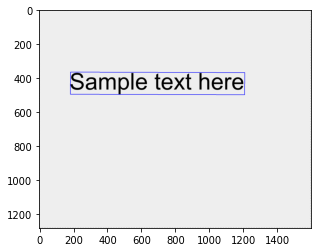

In [54]:
plt.imshow(image)

In [55]:
!pip install easyocr

In [60]:
import easyocr
reader = easyocr.Reader(['th','en'])

In [61]:
result = reader.readtext(os.path.join(os.getcwd(),'images','final_5bc92c94579a1700125f80f7.jpg'))

In [81]:
print(result[0][0][0][1])

350


In [88]:
img = cv2.imread(os.path.join(os.getcwd(),'images','final_5bc92c94579a1700125f80f7.jpg'))

In [89]:
import numpy as np

In [90]:
pts = np.array(result[0][0])

In [91]:
pts

array([[ 172,  350],
       [1221,  350],
       [1221,  509],
       [ 172,  509]])

In [92]:
img = cv2.polylines(img, [pts], True, (255,0,0), 2)

In [93]:
org = (result[0][0][0][0],result[0][0][0][1]-30)
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 2
color = (255,0,0)
thickness = 2

In [94]:
img = cv2.putText(img, result[0][-2] , org, font, fontScale, color, thickness, cv2.LINE_AA)

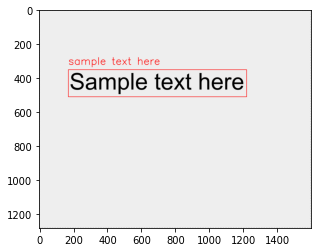

In [95]:
plt.imshow(img)